In [541]:

import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from IPython.display import display
import json


In [542]:
def extract_chosen_isolates(
    chosen_isolates: pd.DataFrame, matrix_EU: pd.DataFrame
) -> pd.DataFrame:
    """
    Select the chosen isolates from the script. Return a DataFrame only containing the rows of selected isolates
    """
    chosen_rows = matrix_EU["Isolate"].isin(chosen_isolates["Isolate"])
    return matrix_EU[chosen_rows]

In [543]:
def extract_valid_ranges(antibiotic_ranges: dict) -> dict:
    """Extracts the upper and lower limit of an antibiotic from a dictionary"""
    valid_ranges = {}
    for antibiotic, conc_range in antibiotic_ranges['ASTar BC G+ (development)'].items():
        lower_limit, upper_limit = conc_range.split()[::2] # remove '-' from list using [::2]
        valid_ranges[antibiotic] = (lower_limit, upper_limit)
    return valid_ranges

In [544]:
def find_digits(SIR: str) -> int:
    """Find numbers in a string"""
    digit = ""
    for character in SIR:
        if character.isdigit() or character == ".":
            digit += character
    return float(digit)

In [545]:
def parse_SIR(SIR: str) -> bool:
    """
    Find the isolates with valid SIRs. Not 'Missing BP'
    and not 'nip'.
    """
    if SIR.startswith("Missing BP"):
        return False
    if SIR == "nip":
        return False
    return True      

In [546]:
def extract_SIR(chosen_isolates: pd.DataFrame, antibiotics: list) -> dict:
    """
    Extract all SIRs for an antibiotic. Returns a dictionary
    with antibiotcs as keys and lists of the isolates and their
    SIRs in tuples as value.
    """
    chosen_isolates_SIR = {antibiotic: [] for antibiotic in antibiotics}
    
    for index, row in chosen_isolates.iterrows():
        isolate, pathogen, antibiotic_SIR = row[0], row[1], list(row[3:].items())
        for antibiotic, SIR in antibiotic_SIR:
            if parse_SIR(SIR):
                mic_category = SIR[0]
                mic = find_digits(SIR)
                chosen_isolates_SIR[antibiotic].append((isolate, np.log2(mic), mic_category))
            else:
                # If SIR = "Missing BP" or "nip"
                chosen_isolates_SIR[antibiotic].append((isolate, SIR, None))
    return chosen_isolates_SIR

In [547]:
def extract_mic_data(chosen_isolates_SIR: dict, antibiotics: list) -> list:
    """
    Extract the mic-values of each isolate for each antibiotic.
    Returns a nested list. Each list represents the mic-values of 
    all isolates for an antibiotic.
    """
    mic_values = []
    # Iterate over all antibiotics
    for antibiotic in antibiotics:
        # Create a list to hold the mic-values of isolates for that abx
        antibiotic_mic_values = []
        # Get value of current abx. List of (isolate, mic_value, mic_category)
        SIR_data = chosen_isolates_SIR[antibiotic]
        for isolate, mic_value, mic_category in SIR_data:
            antibiotic_mic_values.append((isolate, mic_value, mic_category))
        mic_values.append(antibiotic_mic_values)
    return mic_values

In [548]:
def filter_mic_values(chosen_isolates_SIR: dict) -> None:
    """
    Remove the tuples that have None in their SIR data
    """
    for antibiotic, SIR_data in chosen_isolates_SIR.items():
        # tup = (isolate, mic_value, mic_category)
        chosen_isolates_SIR[antibiotic] = list((tup for tup in SIR_data if tup[2] is not None))
    return chosen_isolates_SIR

In [549]:
def count_isolates_per_concentration_per_antibiotic(chosen_isolates_SIR: dict, concentration_range: list, antibiotics: list) -> dict:
    isolates_per_concentration_per_antibiotic = {antibiotic: {conc: 0 for conc in concentration_range} for antibiotic in antibiotics}
    for abx, SIR_data in chosen_isolates_SIR.items():
        for (isolate, mic_value, mic_category) in SIR_data:
            isolates_per_concentration_per_antibiotic[abx][mic_value] += 1
        
        isolates_per_concentration_per_antibiotic[abx] = dict(sorted(isolates_per_concentration_per_antibiotic[abx].items()))
    return isolates_per_concentration_per_antibiotic

In [550]:
def collect_number_of_isolates_per_concentration(isolates_per_concentration_per_antibiotic: dict, concentration_range: list) -> dict:
    number_of_isolates_per_concentration = {conc: [] for conc in concentration_range}
    for antibiotic, isolates_per_concentration in isolates_per_concentration_per_antibiotic.items():
        for concentration, number_of_isolates in isolates_per_concentration.items():
            number_of_isolates_per_concentration[concentration].append(number_of_isolates)
    return number_of_isolates_per_concentration
            

In [551]:

def dotplot(antibiotics: list, concentration_range: list, mic_data: list) -> None:    
    mic_dict = {"S": ("limegreen", "Sensitive"), "I": ("gold", "Intermediate"), "R": ("tomato", "Resistant")}
    
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    
    
    jitter = 0.15
    x_axis = [i for i in range(len(antibiotics))]
    for x_value, abx_mic_data in zip(x_axis, mic_data):
        for _, mic_value, mic_category in abx_mic_data:
            try:
                color, _ = mic_dict[mic_category]            
            except ValueError:
                raise ValueError(f"Invalid key for mic_dict. Please use S, I or R. Entered key: {mic_category}")
            x_value_jitter = x_value + np.random.uniform(-jitter, jitter)
            mic_value_jitter = mic_value + np.random.uniform(-jitter, jitter)
            ax.scatter(x_value_jitter, mic_value_jitter, color=color, edgecolors=color, alpha=0.5)
    
    green_patch = mpatches.Patch(color=mic_dict["S"][0], label=mic_dict["S"][1])
    yellow_patch = mpatches.Patch(color=mic_dict["I"][0], label=mic_dict["I"][1])
    red_patch = mpatches.Patch(color=mic_dict["R"][0], label=mic_dict["R"][1])
    
    
    # add labels and title
    ax.set_xticks(x_axis)
    ax.set_xticklabels(antibiotics, rotation=90)
    ax.set_yticks(concentration_range)
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set(xlabel="Antibiotics", ylabel="log2(MIC Values)")
    ax.set_title('log2(MIC Values) for Different Strains')
    plt.legend(handles=[green_patch, yellow_patch, red_patch])
    # display plot
    plt.show()

In [552]:
def filter_isolates_per_concentration(isolates_per_concentration: dict) -> dict:
    """Removes concentrations where no isolates appear"""
    filtered_isolates_per_concentration = {}
    for concentration, number_of_isolates in isolates_per_concentration.items():
        # If the concentration has 0 isolates for all antibiotics, leave it
        if all(n == 0 for n in number_of_isolates):
           pass
        else: 
        # Add it to the filtered dictionary else
            filtered_isolates_per_concentration[concentration] = number_of_isolates
    return filtered_isolates_per_concentration

In [553]:
def stacked_bar_plots(antibiotics: list, isolates_per_concentration: dict, sir_threshold:dict,width: float=0.5) -> None:
    # Set up color gradient
    filtered_isolates_per_concentration = filter_isolates_per_concentration(isolates_per_concentration)
    NUM_COLORS = len(filtered_isolates_per_concentration)
    cm = plt.get_cmap("gist_rainbow")
    
    fig, ax = plt.subplots()
    
    # Leave empty space on right side for legend
    fig.subplots_adjust(right=0.8)
    bottom = np.zeros(len(antibiotics))
    
    for index, (concentration, number_of_isolates) in enumerate(filtered_isolates_per_concentration.items()):
        color = cm(index/NUM_COLORS)
        ax.bar(antibiotics, number_of_isolates, width=width, label=round(2**concentration, 5), bottom=bottom, color=color)
        bottom += number_of_isolates
    
    plt.xticks(rotation=90)
    ax.set_title("Number of isolates per concentration per antibiotic")

    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels[::-1], labels[::-1],loc="center left", bbox_to_anchor=(0.8, 0.5), bbox_transform=fig.transFigure)

In [562]:

def plotly_dotplot(antibiotics: list, mic_data: list) -> None:    
    mic_dict = {"S": ("limegreen", "Sensitive"), "I": ("gold", "Intermediate"), "R": ("tomato", "Resistant")}
    jitter = 0.15
    x_axis = [i for i in range(len(antibiotics))]
            
    x_values = []
    y_values = []
    SIR_color = []
    isolate_names = []
    for x_value, abx_mic_data in zip(x_axis, mic_data):
        for isolate, mic_value, mic_category in abx_mic_data:
            x_value_jitter = x_value + np.random.uniform(-jitter, jitter)
            mic_value_jitter = mic_value + np.random.uniform(-jitter, jitter)    
            isolate_names.append(isolate)
            x_values.append(x_value_jitter)
            y_values.append(mic_value_jitter)
            SIR_color.append(mic_dict[mic_category][1])
            
               
    df = pd.DataFrame({
        "Antibiotics": x_values,
        "Log2(MIC-value)": y_values,
        "Isolate names": isolate_names,
        "SIR": SIR_color,
    }, index=np.arange(len(x_values)))
    
    fig = px.scatter(
        df, 
        x="Antibiotics", 
        y="Log2(MIC-value)",
        hover_name="Isolate names",
        color="SIR",
        title="Isolate log2(MIC-values) for different antibiotics",
        range_y=[-9, 10],
        hover_data={'Antibiotics':False, 
                    'Log2(MIC-value)':':.0f'
                            }
        )
    
    def change_trace_color(trace):
        if trace.name=="Resistant":
            trace.update(marker_color="tomato")
        elif trace.name == "Intermediate":
            trace.update(marker_color="gold")
        elif trace.name == "Sensitive":
            trace.update(marker_color="limegreen")
        else:
            raise ValueError("Not a valid trace")
    fig.for_each_trace(change_trace_color)
    
    fig.update_layout(
        xaxis=dict(
            tickmode="array",
            tickvals = x_axis,
            ticktext= antibiotics
        )
        
    )
    
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))
    fig.show()
    

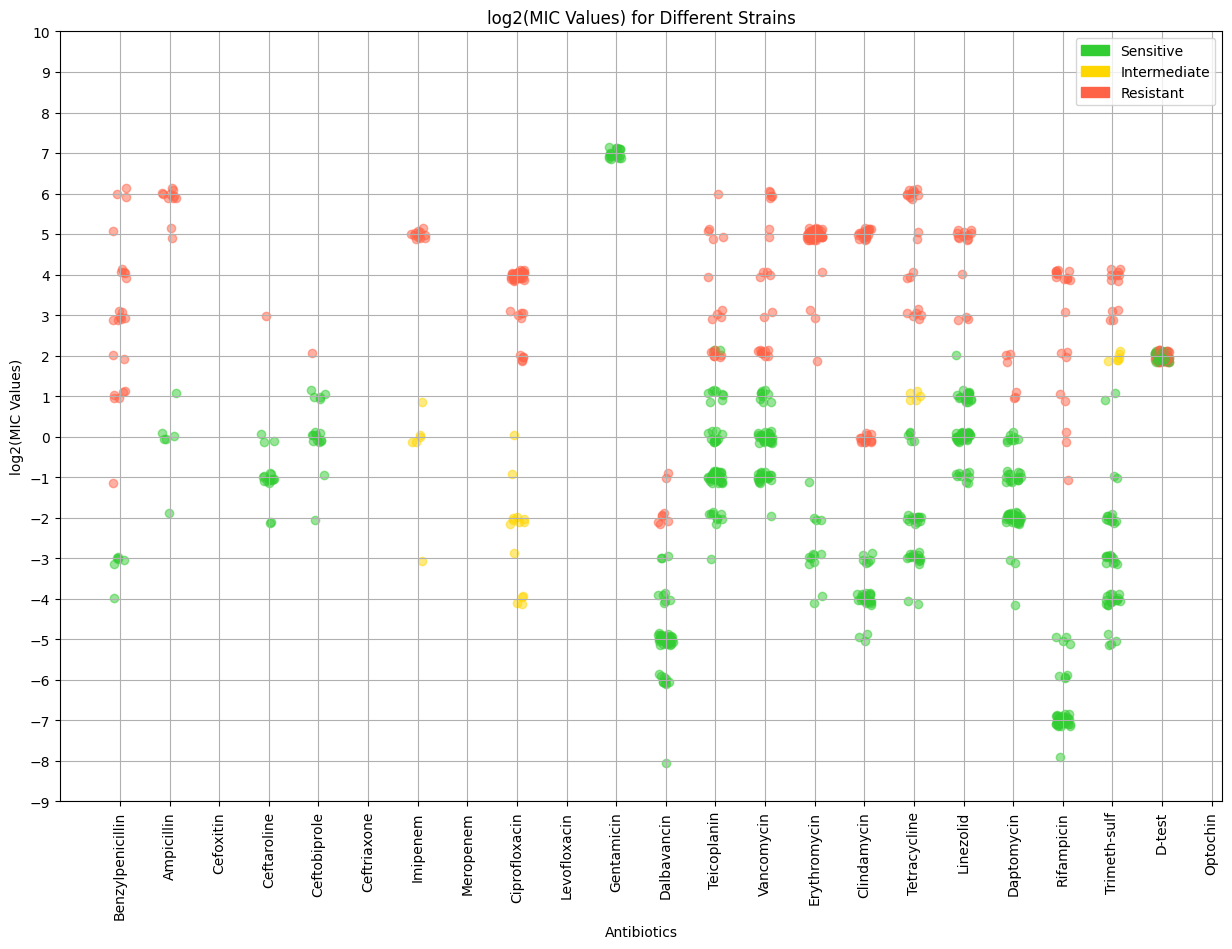

In [563]:
def main():
    # Load files
    chosen_isolates_list = pd.read_csv("Chosen_isolates_list.csv")
    CIB = pd.ExcelFile("CIB_TF-data_AllIsolates_20230302.xlsx")
    matrix_EU = pd.read_excel(CIB, "matrix EU")
    sir_thresholds = json.load(open("sir_thresholds.json"))
    matrix_EU.rename(columns={"Trimethoprim-sulfamethoxazole": "Trimeth-sulf"}, inplace=True)
    
    # Select isolates
    chosen_isolates = extract_chosen_isolates(chosen_isolates_list, matrix_EU)
    
    # Concentrations in panel
    concentration_range = [i for i in range(-9, 11)]
    
    # Create array of isolate names and antibiotic names
    #chosen_isolates_names = chosen_isolates_list.values.reshape(1, -1)[0]
    
    antibiotics = list(chosen_isolates.columns[3:])
    
    # Extract all SIRs for an antibiotic.
    chosen_isolates_SIR = extract_SIR(chosen_isolates, antibiotics)
    
    # Remove the tuples that have None in their SIR data
    filtered_chosen_isolates_SIR = filter_mic_values(chosen_isolates_SIR)
    
    # Count number of isolates per concentration
    isolates_per_concentration_per_antibiotic = count_isolates_per_concentration_per_antibiotic(filtered_chosen_isolates_SIR, concentration_range, antibiotics)
    
    isolates_per_concentration = collect_number_of_isolates_per_concentration(isolates_per_concentration_per_antibiotic, concentration_range)
    
    #stacked_bar_plots(antibiotics, isolates_per_concentration, sir_thresholds)
    
    # Extract the mic-values of each isolate for each antibiotic.
    mic_data = extract_mic_data(filtered_chosen_isolates_SIR, antibiotics)
    
    plotly_dotplot(antibiotics, mic_data)
    dotplot(antibiotics, concentration_range, mic_data)
if __name__ == "__main__":
    main()
